### 梯度下降类优化算法

在深度学习中，目标函数通常是训练数据集中有关各个样本的损失函数的平均。设$f_i(x)$是有关索引为i的训练数据样本的损失函数,n是训练数据样本数，x是模型的参数向量，那么目标函数定义为

$f(x)=\frac{1}{|\beta|}\Sigma_{i \in \beta}f_i(x)$

目标函数在x处的梯度计算为

$g_t \leftarrow \triangledown f_{\beta_{t}}(x)=\frac{1}{|\beta|}\Sigma_{i \in \beta_{t}}\triangledown f_i(x)$

给定学习率$\eta$,则迭代过程如下:

$x_t \leftarrow x_{t-1}-\eta_t g_t$

其中学习率$\eta$和样本数量$|\beta|$是超参数
* 当$|\beta|=1$时，是随机梯度下降算法，随机梯度下降算法在每次迭代中随机采样一个样本来计算梯度，计算开销为O(1)
* 当$|\beta|<训练集总数$时，是小批量随机梯度下降算法，小批量随机梯度下降算法每次迭代时随机采样一小部分数据，同时在迭代过程中学习率会自我衰减，例如$\eta=\eta\alpha^{t}$（比如$\alpha$=0.95）,计算开销为O($|\beta|$)
* 当$|\beta|=训练集总数$时，是梯度下降算法,梯度下降算法在每次迭代时使用了整个训练数据，计算得到的是目标函数的真实梯度

通常，小批量随机梯度在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。

### 简洁实现

在Pytorch里可以通过创建optimizer实例在调用优化算法。这能让实现更简洁。

现在实现一个通用的训练函数，它通过优化算法的函数optimzer_fn和超参数optimzer_hyperparms来创建optimzer实例

In [1]:
import numpy as np
import torch 
from torch import nn,optim
import utils
import time
import matplotlib.pyplot as plt
#读取数据
def get_data_ch7():
    data=np.genfromtxt('/home/wushukun/jupyterHome/remotePython/DeepLearning/Dataset/airfoil_self_noise.dat',delimiter='\t')
    data=(data-data.mean(axis=0)/data.std(axis=0))
    return torch.tensor(data[:1500,:-1],dtype=torch.float32), \
            torch.tensor(data[:1500,-1],dtype=torch.float32)

In [2]:
features,labels=get_data_ch7()
features.shape

torch.Size([1500, 5])

In [6]:
#optimzer_Fn是参数优化函数而不是优化器的名字
#例如:optimizer_fn=torch.optim.SGD,optimizer_hyperparam={"lr":0.05}
def train_pytorch_ch7(optimizer_fn,optimizer_hyperparams,features,labels,
                     batch_size=10,num_epochs=2):
    #初始化模型
    net=nn.Sequential(nn.Linear(features.shape[-1],1))
    
    loss=nn.MSELoss()
    optimizer=optimizer_fn(net.parameters(),**optimizer_hyperparams)
    
    #计算的是所有训练数据的损失
    def eval_loss():
        return loss(net(features).view(-1),labels).item()/2
    
    
    ls=[eval_loss()]
    data_iter=torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(features,labels),batch_size,shuffle=True)
    
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            #除以2是为了和eval_loss中保持一致，因为eval_loss中除了2
            l=loss(net(X).view(-1),y)/2
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            #print('batch_i',batch_i,'batch_size',batch_size)
            
            if (batch_i+1)*batch_size % 100==0:
                ls.append(eval_loss())
                
    #打印结果
    print('loss:%f, %f sec per epoch'%(ls[-1],time.time()-start))
            
    utils.set_figsize()
    utils.plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    utils.plt.xlabel('epoch')
    utils.plt.ylabel('loss')
            

loss:nan, 0.080740 sec per epoch


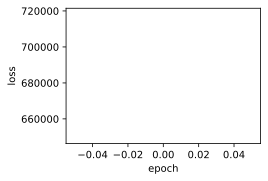

In [7]:
train_pytorch_ch7(optim.SGD,{'lr':0.05},features,labels,10)